In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read the pickle file
with open('../tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)

In [4]:
ball_positions = [position.get(1, []) for position in ball_positions]
# convert the list into pandas dataframe
df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2'])
# interpolate the missing values
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()  # fill the first missing value

In [5]:
df_ball_positions

,x1,y1,x2,y2
0,895.494934,613.216064,909.893799,637.401917
1,895.494934,613.216064,909.893799,637.401917
2,880.366913,629.028168,894.236511,653.047852
3,865.238892,644.840271,878.579224,668.693787
4,851.644348,655.517181,866.356140,680.955383
...,...,...,...,...
209,1186.063110,245.564392,1197.347778,266.479431
210,1185.235229,232.353607,1195.867065,249.535950
211,1184.643677,225.718338,1194.353027,242.845474
212,1180.485718,212.513458,1191.873413,232.231537


In [6]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2'])/2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

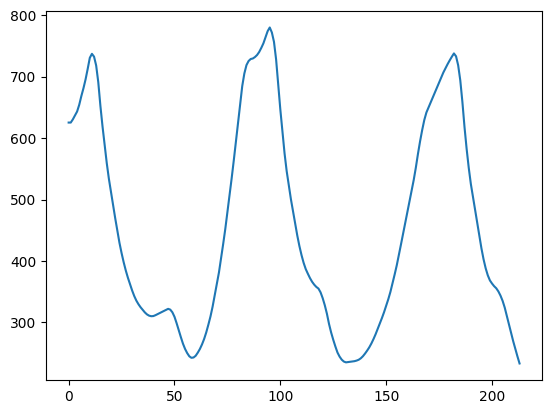

In [7]:
plt.plot(df_ball_positions['mid_y_rolling_mean'])

In [8]:
df_ball_positions

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean
0,895.494934,613.216064,909.893799,637.401917,625.308990,625.308990
1,895.494934,613.216064,909.893799,637.401917,625.308990,625.308990
2,880.366913,629.028168,894.236511,653.047852,641.038010,630.551997
3,865.238892,644.840271,878.579224,668.693787,656.767029,637.105755
4,851.644348,655.517181,866.356140,680.955383,668.236282,643.331860
...,...,...,...,...,...,...
209,1186.063110,245.564392,1197.347778,266.479431,256.021912,283.227705
210,1185.235229,232.353607,1195.867065,249.535950,240.944778,269.329961
211,1184.643677,225.718338,1194.353027,242.845474,234.281906,256.820222
212,1180.485718,212.513458,1191.873413,232.231537,222.372498,244.649180


In [9]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()

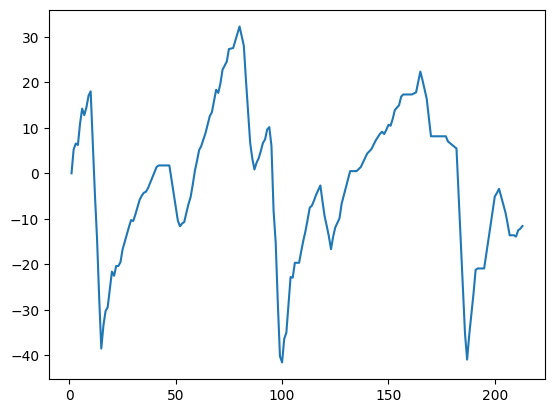

In [10]:
# plot mid_y_rolling_mean
plt.plot(df_ball_positions['delta_y'])

In [12]:
df_ball_positions

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y
0,895.494934,613.216064,909.893799,637.401917,625.308990,625.308990,NaN
1,895.494934,613.216064,909.893799,637.401917,625.308990,625.308990,0.000000
2,880.366913,629.028168,894.236511,653.047852,641.038010,630.551997,5.243006
3,865.238892,644.840271,878.579224,668.693787,656.767029,637.105755,6.553758
4,851.644348,655.517181,866.356140,680.955383,668.236282,643.331860,6.226105
...,...,...,...,...,...,...,...
209,1186.063110,245.564392,1197.347778,266.479431,256.021912,283.227705,-13.602897
210,1185.235229,232.353607,1195.867065,249.535950,240.944778,269.329961,-13.897744
211,1184.643677,225.718338,1194.353027,242.845474,234.281906,256.820222,-12.509739
212,1180.485718,212.513458,1191.873413,232.231537,222.372498,244.649180,-12.171041


In [13]:
df_ball_positions['ball_hit']=0

In [14]:
minimum_change_frames_for_hit = 25
for i in range(1,len(df_ball_positions)- int(minimum_change_frames_for_hit*1.2) ):
    negative_position_change = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[i+1] <0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[i+1] >0

    if negative_position_change or positive_position_change:
        change_count = 0 
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[change_frame] <0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[change_frame] >0

            if negative_position_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_position_change and positive_position_change_following_frame:
                change_count+=1
    
        if change_count>minimum_change_frames_for_hit-1:
            df_ball_positions['ball_hit'].iloc[i] = 1

/var/folders/pp/_zphjjhd1qxbfsb5gcz02cgc0000gn/T/ipykernel_3251/4206690981.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ball_positions['ball_hit'].iloc[i] = 1
/var/folders/pp/_zphjjhd1qxbfsb5gcz02cgc0000gn/T/ipykernel_3251/4206690981.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ball_positions['ball_hit'].iloc[i] = 1
/var/folders/pp/_zphjjhd1qxbfsb5gcz02cgc0000gn/T/ipykernel_3251/4206690981.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [15]:
frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()

In [16]:
frame_nums_with_ball_hits

[11, 58, 95, 131, 182]

In [17]:
df_ball_positions[df_ball_positions['ball_hit']==1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,778.502441,712.936951,797.597046,744.632324,728.784637,737.213892,6.482080,1
58,925.734619,234.979843,936.973022,254.383255,244.681549,242.295241,-2.473352,1
95,617.552917,765.018738,638.274597,801.817444,783.418091,780.114191,6.042822,1
131,717.737976,225.710945,729.861938,246.005646,235.858295,234.894468,-1.307329,1
182,1297.982300,738.454163,1311.825439,762.185181,750.319672,737.862067,5.453790,1
